# Titanic Survival Prediction: Exploratory Data Analysis  
*~ "Extracting Signals from Complex Data"*

## Objective  
This project investigates survival outcomes in the Titanic dataset through systematic exploratory data analysis. The goal is to identify key patterns and relationships between passenger attributes and survival, with a strong focus on feature interpretation and non-linear interactions.

By treating this as a binary classification task, we aim to:

- Understand which features are most predictive of survival.  
- Engineer meaningful variables from existing data.  
- Explore hidden patterns that may inform future predictive modeling.

---

## Key Questions  

**1. Feature Engineering**  
- Does `Fare` correlate with survival in a meaningful, non-linear way?  
- Can titles from `Name` (e.g., Mr., Mrs., Master) reflect social roles or behavior during crisis?

**2. Understanding Risk Factors**  
- How does `Pclass` interact with `Age` in shaping survival likelihood?  
- Do missing values in `Cabin` indicate an underlying pattern or randomness?

**3. Modeling Considerations**  
- Should `SibSp` and `Parch` be treated independently, or as a combined family size metric?  
- Does `Embarked` reveal differences in survival based on boarding location?

---

## 🔍 Additional Questions to Investigate

### 1. Interaction Effects
- **Does Age interact with Sex and Pclass?**  
  → Younger females in higher classes may have very different survival patterns than older males in lower classes.

- **Do family size and ticket fare show interaction effects?**  
  → Consider `Fare per person = Fare / (SibSp + Parch + 1)`.

### 2. Nonlinear Relationships
- **Is the relationship between Age/Fare and survival linear or segmented?**  
  → Use decision trees or spline transforms to capture thresholds (e.g., age < 10 or Fare > 50).

### 3. High-cardinality Variables
- **Are there passengers with the same Ticket number?**  
  → Could indicate group travel. Encode group size using ticket counts.

- **Does Cabin contain structure (e.g., deck letter A–G)?**  
  → Extract the first letter of the cabin (deck) to test for location effects.

### 4. Data Quality / Missingness
- **Are missing values informative?**  
  → If most Cabin values are missing, test whether missingness itself correlates with survival. Create `Cabin_missing` as a binary feature.

### 5. Redundancy / Correlation
- **Is `SibSp + Parch` correlated with survival or with other features?**  
  → Create `FamilySize`, `IsAlone = (FamilySize == 1)`, and evaluate their predictive value.

- **Do Embarked and Pclass interact?**  
  → Certain ports might have more lower-class passengers. Consider creating cross features.

### 6. Outlier Detection
- **Are there outliers in Fare or Age?**  
  → Use boxplots or Z-scores. Consider capping/extending features or adding outlier flags.

---

## 📌 Bonus Modeling Considerations

- **Target leakage check:**  
  Ensure no features "leak" survival info indirectly (e.g., post-rescue data).

- **Class imbalance:**  
  Is the dataset imbalanced? Consider stratified sampling, class weighting, or using ROC-AUC/F1-score.

- **Feature importance validation:**  
  After modeling, revisit which features are most important. Did they align with EDA expectations?

---

## Methodology  

1. **Group-Based Survival Analysis**  
   - Compute survival rates across demographic and ticketing groups (e.g., by Sex, Pclass, Title).

2. **Data Visualization**  
   - Use heatmaps to examine feature correlations.  
   - Apply kernel density estimation (KDE) to explore distributions of numerical variables such as `Age` and `Fare`.  

3. **Statistical Testing**  
   - Perform Chi-square tests to assess dependence between categorical features and survival.  
   - Use the Kolmogorov–Smirnov test to compare numerical distributions between survived and non-survived passengers.

In [3]:
# Tools

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [4]:
# 1. Initial setup

# Load the data
df = pd.read_csv('../data/raw/train.csv')

# Quick overview of the data
print("Train Data:")
print(df.head())
print(df.info())
print(df.describe(include="all"))

Train Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN  

From the EDA we can see that the columns can be categorised into the following:  
Target: 'Survived'  
ID: ['PassengerId', 'Name', 'Ticket', 'Cabin']  
Categorical: ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']  
Numerical: ['Age', 'Fare']  

The following cols have missing data: Age (~20% Missing), Cabin (~77% Missing), Embarked (~.2% Missing)

<Axes: >

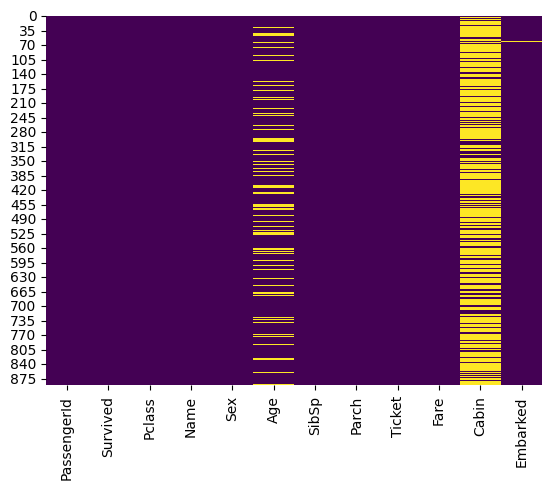

In [ ]:
# 2. Visualise the missing data

# Heatmap of missingness
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")

In [5]:
df['Deck'] = df['Cabin'].str[0]
df['Cabin_missing'] = df['Cabin'].isnull().astype(int)
df['Age_missing'] = df['Age'].isnull().astype(int)

Cabin  
Observation: Vertical bar mostly filled in → ~77% missing  
Conclusion:
- Too sparse to impute reliably
- Missingness may correlate with class/wealth → useful as a binary flag
- Action: Extract Deck (categorical) from existing Cabin values + create Cabin_missing (binary/categorical) flag


Age  
Observation: Random scatter of missing cells  
Conclusion:
- Likely Missing At Random (MAR), not structurally biased
- Imputation (e.g., median by Sex and Pclass) is acceptable
- Action: For now, flag as Age_missing (binary/categorical) during EDA; impute later for modeling


Embarked  
Observation: Just 2 missing cells  
Conclusion:
- Not meaningful enough to worry about
- Action: Impute with the mode ('S', usually the most common embark point)

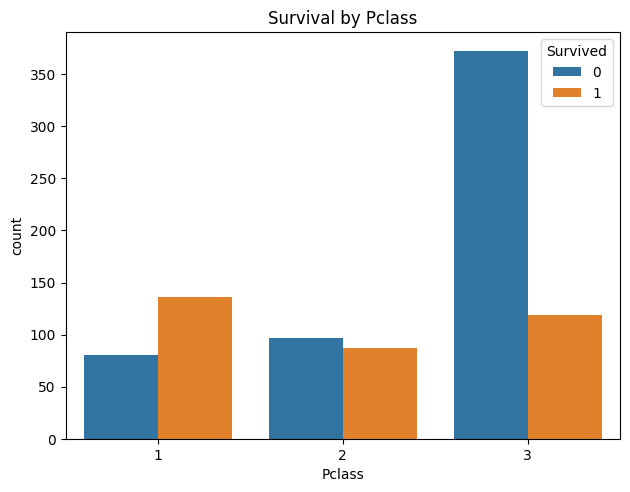

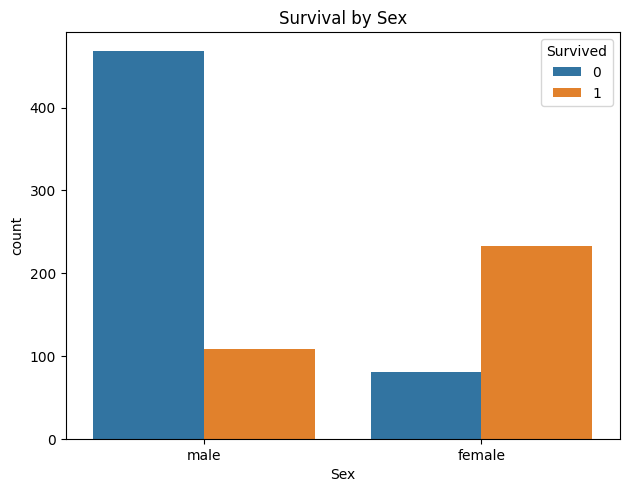

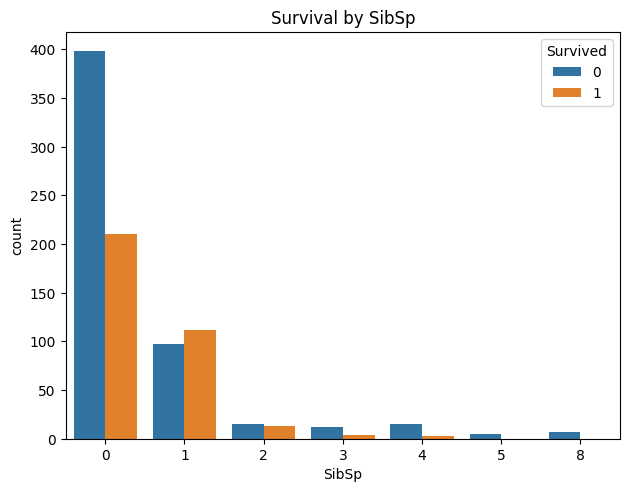

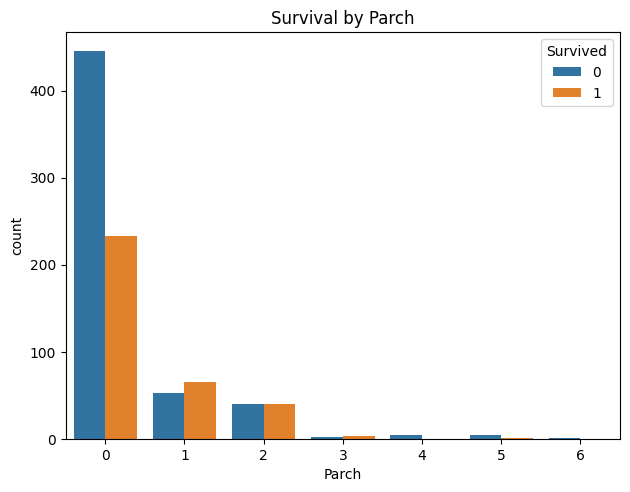

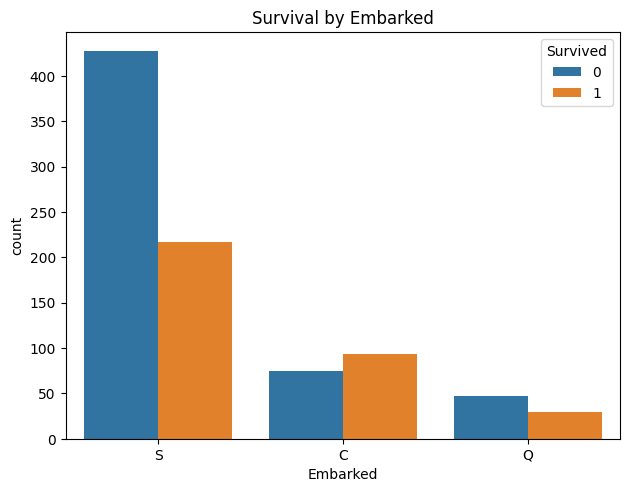

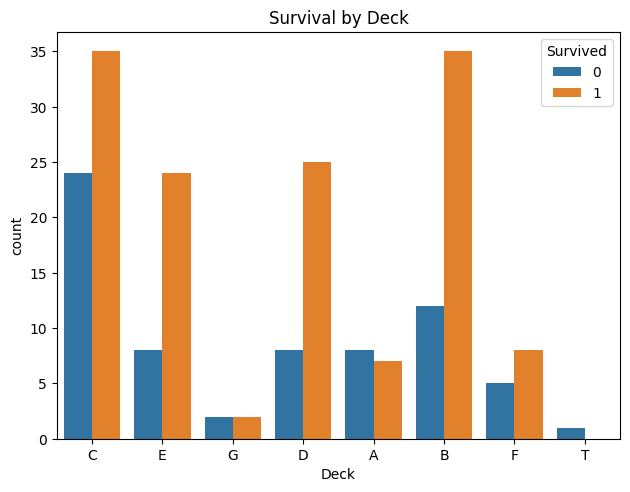

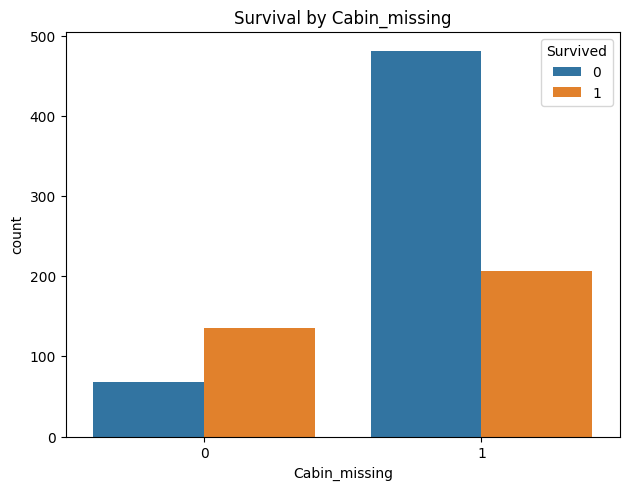

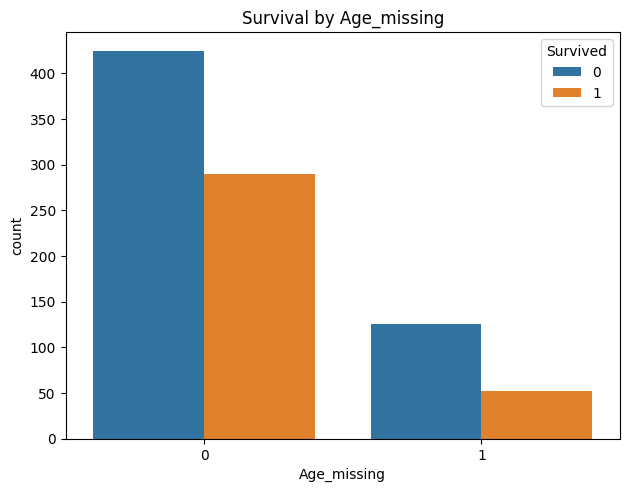

In [6]:
# 3. Univariate Analysis

categorical = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Deck', 'Cabin_missing', 'Age_missing']
for col in categorical:
    sns.countplot(x=col, data=df, hue='Survived')
    plt.tight_layout()
    plt.title(f"Survival by {col}")
    plt.show()


- **Pclass**: Passengers in Class 3 have a significantly lower survival rate.
- **Sex**: Females have a much higher chance of survival.
- **SibSp**: Passengers with 0 siblings/spouses aboard tend to have lower survival rates.
- **Parch**: Similar to SibSp — those with 0 parents/children aboard are less likely to survive.
- **Embarked**: Embarked from port 'S' shows the lowest survival rates.
- **Deck**: Passengers on Decks C, E, D, and B show higher survival probabilities.
- **Cabin_missing**: Those missing a Cabin number are less likely to survive — indicates lower class or less documentation.
- **Age_missing**: Missing age values correlate with lower survival rates, suggesting some hidden bias in documentation.

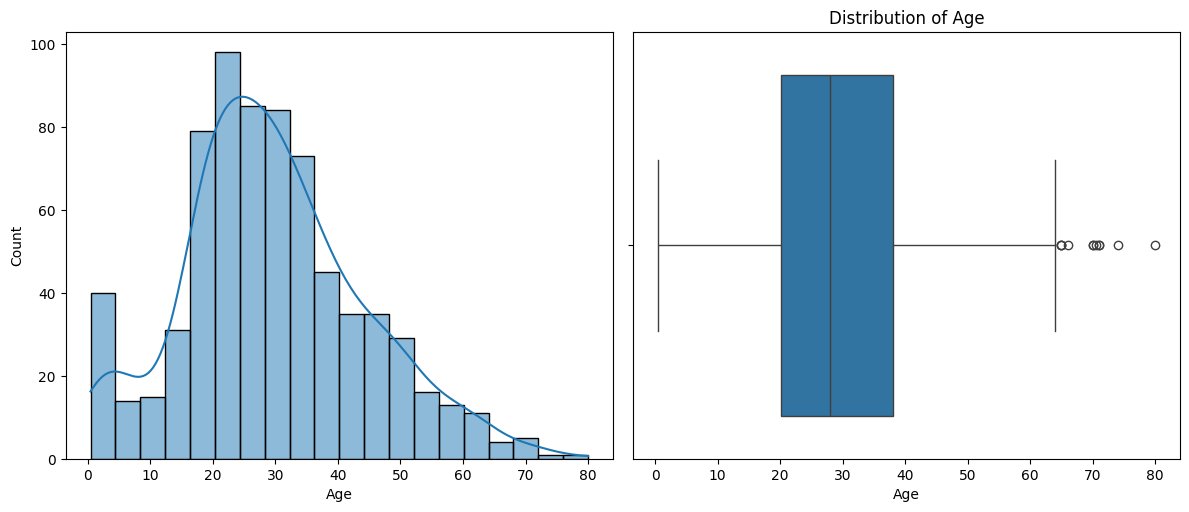

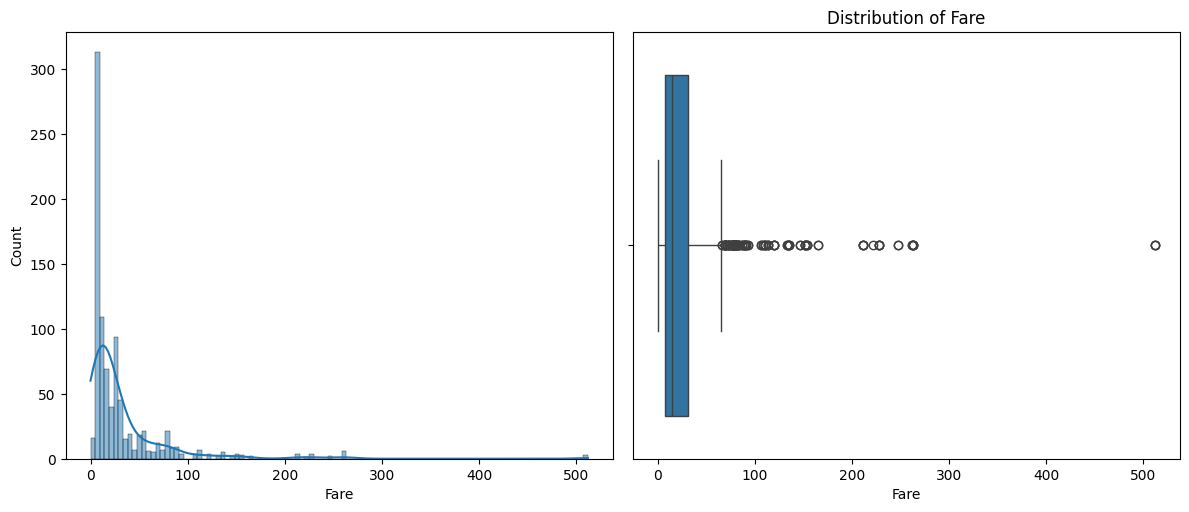

In [7]:
numerical = ['Age', 'Fare']
for col in numerical:
    f, axes = plt.subplots(1, 2, figsize=(12,5))
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(x=df[col], ax=axes[1])
    plt.tight_layout()
    plt.title(f"Distribution of {col}")
    plt.show()


- **Age**: Distribution is slightly right-skewed but nearly normal, with some outliers on the right (older passengers).
- **Fare**: Highly right-skewed distribution with many high-value outliers — suggests need for log transformation to normalize.

In [31]:
# 4. Bivariate Analysis

# Survival rates by group
for col in categorical:
    # print(f'Survival rates by {col}:')
    print(df.groupby(col)['Survived'].mean())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64
SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64
Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64
Deck
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Name: Survived, dtype: float64
Cabin_missing
0    0.666667
1    0.299854
Name: Survived, dtype: float64
Age_missing
0    0.406162
1    0.293785
Name: Survived, dtype: float64


How We Interpret Group Survival Rates:

| Range of Group Survival Rates | Meaning                         | Modeling Implication        |
|------------------------------|----------------------------------|-----------------------------|
| **> 30% difference**         | Strong signal                    | ✅ Keep — likely predictive |
| **15%–30%** difference       | Moderate signal                  | ⚠️ Consider keeping or transforming |
| **< 15%** difference         | Weak signal                      | 🚫 Consider dropping or combining |

| Feature         | Max – Min Survival Rate | Interpretation & Action |
|----------------|--------------------------|--------------------------|
| **Sex**        | 0.74 – 0.19 = **55%**    | ✅ Very strong predictor — keep |
| **Pclass**     | 0.63 – 0.24 = **39%**    | ✅ Strong — keep |
| **Embarked**   | 0.55 – 0.34 = **21%**    | ⚠️ Moderate — keep |
| **Deck**       | 0.76 – 0.00 = **76%**    | ✅ Very strong — validate Deck T (1 person) |
| **SibSp**      | 0.54 – 0.00 = **54%**    | ✅ Strong — consider binning SibSp > 2 |
| **Parch**      | 0.60 – 0.00 = **60%**    | ✅ Strong — binning may help |
| **Cabin_missing** | 0.67 – 0.30 = **37%** | ✅ Strong — keep as binary indicator |
| **Age_missing**  | 0.41 – 0.29 = **12%**  | 🚫 Weak — borderline useful, maybe keep for tree models |

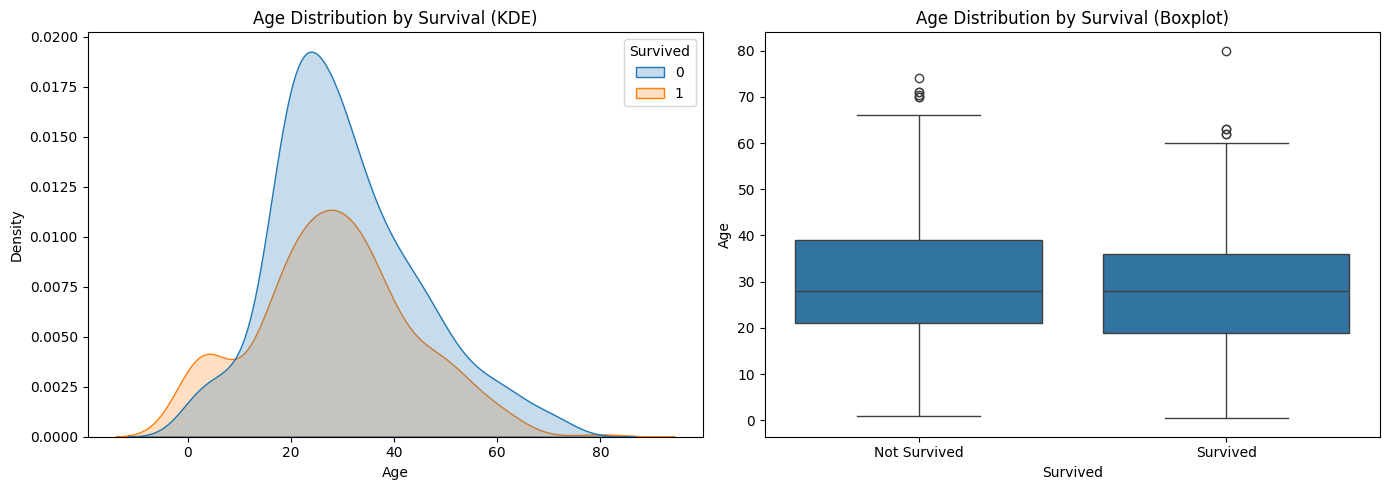

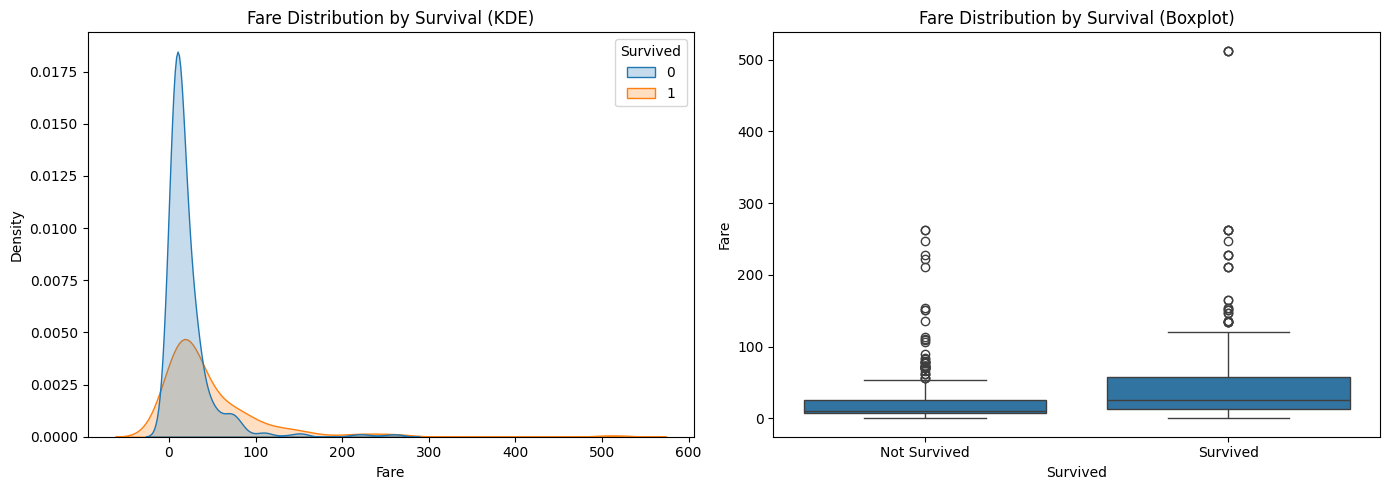

In [8]:
for col in numerical:
    f, axes = plt.subplots(1, 2, figsize=(14,5))
    
    # KDE plot
    sns.kdeplot(data=df, x=col, hue='Survived', fill=True, ax=axes[0])
    axes[0].set_title(f"{col} Distribution by Survival (KDE)")
    
    # Boxplot
    sns.boxplot(x='Survived', y=col, data=df, ax=axes[1])
    axes[1].set_title(f"{col} Distribution by Survival (Boxplot)")
    axes[1].set_xticks([0,1])
    axes[1].set_xticklabels(['Not Survived', 'Survived'])
    
    plt.tight_layout()
    plt.show()

**Age**:  
- The **Age** distribution among survivors is concentrated at younger ages, indicating that children and young adults had better survival rates.
- Non-survivors tend to be older and exhibit a wider spread in ages.
- This is visible in the KDE plot where the survivor peak is shifted left (younger), and confirmed in the boxplot where survivors show a lower median age.
- Outliers on the right side (very old passengers) are more common in non-survivors.

**Fare**:  
- The **Fare** distribution is highly right-skewed for both survivors and non-survivors, with many outliers paying very high fares.
- Survivors generally paid higher fares, suggesting that higher socioeconomic status was associated with higher survival chances.
- The boxplot highlights these extreme outliers and shows a higher median fare among survivors.
- Given this skewness and outliers, applying a log transformation to Fare before modeling would likely improve model performance.

c:\Users\Jay Tai\Documents\Titanic-Kraggle-Competition\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


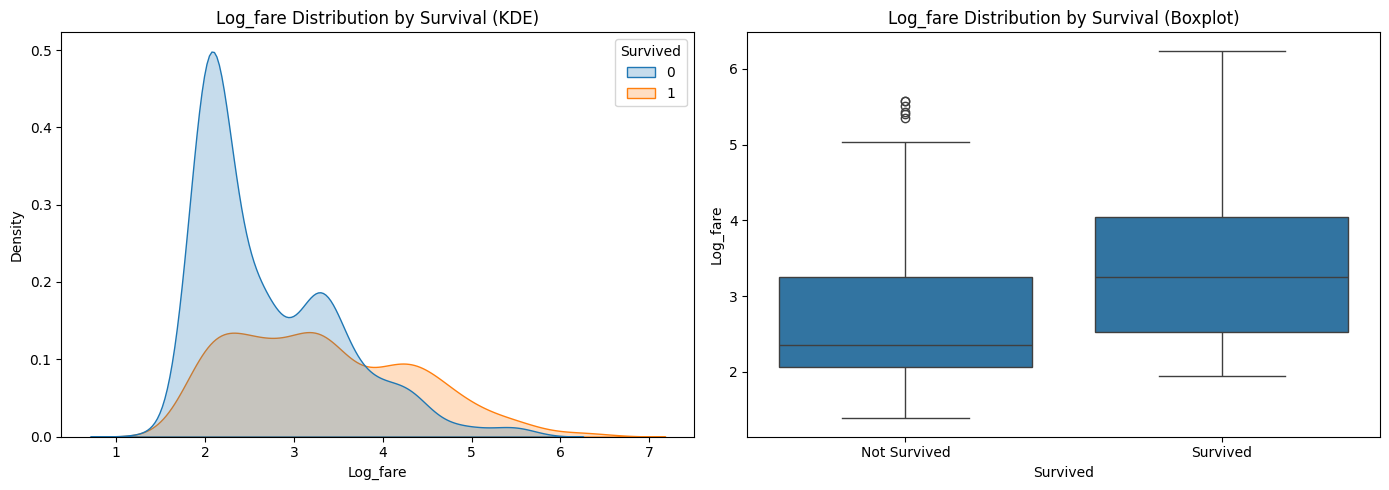

In [10]:
# We want to make Log transform Fare to make it more normally distributed

import numpy as np
df['Log_fare'] = np.log(df['Fare'])

col = 'Log_fare'

f, axes = plt.subplots(1, 2, figsize=(14,5))
    
# KDE plot
sns.kdeplot(data=df, x=col, hue='Survived', fill=True, ax=axes[0])
axes[0].set_title(f"{col} Distribution by Survival (KDE)")
    
    # Boxplot
sns.boxplot(x='Survived', y=col, data=df, ax=axes[1])
axes[1].set_title(f"{col} Distribution by Survival (Boxplot)")
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['Not Survived', 'Survived'])
    
plt.tight_layout()
plt.show()

Key Observations:
Separation of Distributions

Survivors (1) show higher density at higher Log_Fare values (~6-7) compared to non-survivors (0).

Non-survivors are concentrated at lower Log_Fare values (~4-5).

Right-Skewed Survivor Distribution

Survivors have a longer right tail, indicating some paid significantly higher fares.

Overlap Region (~5-6)

Both groups overlap here, suggesting fare alone isn’t a perfect predictor.


Feature Engineering

- Bin Log_Fare into categories (e.g., "Low (<5)", "Medium (5-6)", "High (>6)") to capture non-linear effects. (for things like dt, else leave it as is for LM)

- Interaction Terms: Combine with Pclass (e.g., High_Fare_1stClass).

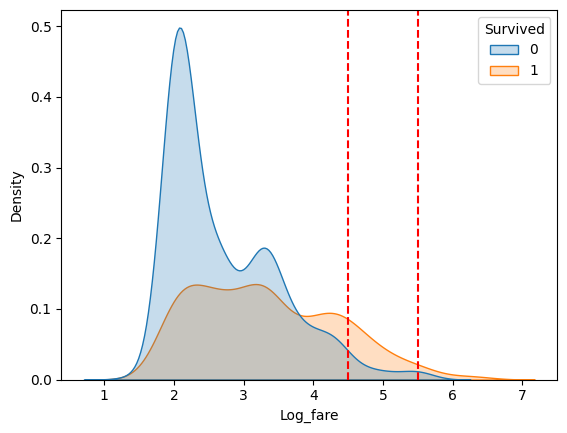

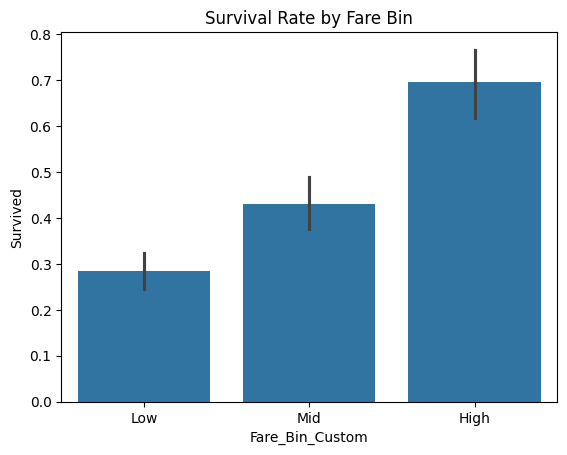

Fare_Bin_Custom
Low     0.284000
Mid     0.429787
High    0.695035
Name: Survived, dtype: float64
Fare_Bin_Custom
Low     500
Mid     235
High    141
Name: Survived, dtype: int64


In [48]:
# Plot KDE to visually identify peaks
sns.kdeplot(data=df, x='Log_fare', hue='Survived', fill=True)
plt.axvline(4.5, color='red', linestyle='--')  # Hypothetical low/mid threshold
plt.axvline(5.5, color='red', linestyle='--')  # Hypothetical mid/high threshold
plt.show()

a = None
# Manually define bins based on visual inspection
bins = [0, 3, 4, 10.0]
labels = ['Low', 'Mid', 'High']
df['Fare_Bin_Custom'] = pd.cut(df['Log_fare'], bins=bins, labels=labels)

sns.barplot(x='Fare_Bin_Custom', y='Survived', data=df)
plt.title('Survival Rate by Fare Bin')
plt.show()

# Validate survival rates
print(df.groupby('Fare_Bin_Custom', observed=True)['Survived'].mean())
print(df.groupby('Fare_Bin_Custom', observed=True)['Survived'].count())

We now try to answer some questions we set out to answer at the start:

Does Fare correlate with survival in a meaningful, non-linear way?

Yes. Fare is skewed so we applied log transform onto it to normalise the data. We further categorised them into bins to further capture its non-linear relationships in a categorical sense.

Titles
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64


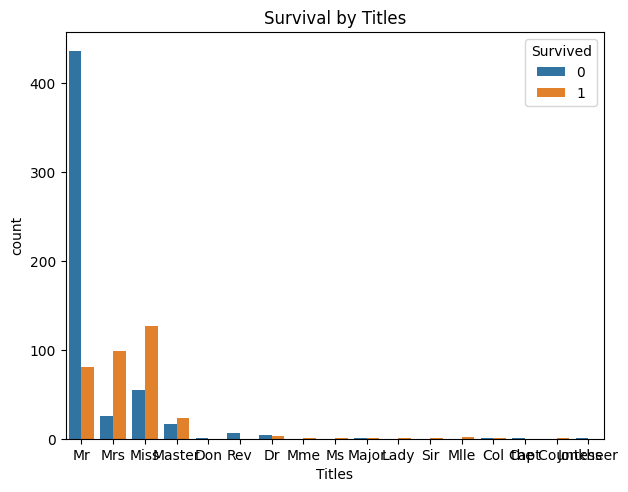

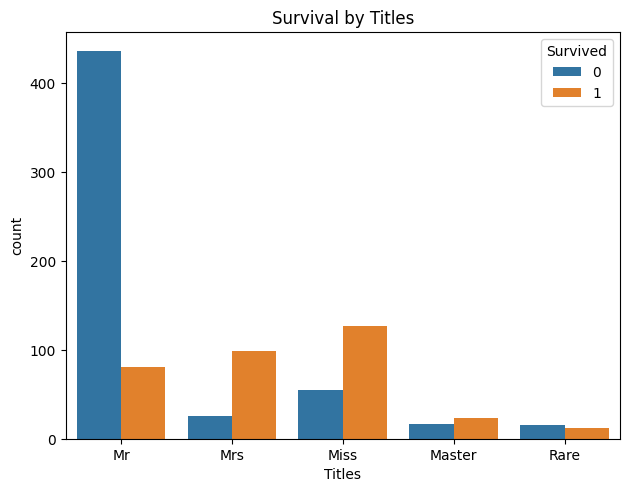

Titles
Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: count, dtype: int64
Titles
Master    0.575000
Miss      0.697802
Mr        0.156673
Mrs       0.792000
Rare      0.444444
Name: Survived, dtype: float64


In [71]:
# - Can titles from Name (e.g., Mr., Mrs., Master) reflect social roles or behavior during crisis?

# for this we want to extract the titles from the name col and run an analysis of it against the survival col

df['Titles']=  df['Name'].apply(lambda x: x.split(', ')[1].split('. ')[0])

col = 'Titles'

print(df[col].value_counts())

sns.countplot(x=col, data=df, hue='Survived')
plt.tight_layout()
plt.title(f"Survival by {col}")
plt.show()

# grouping the rare titles together:
rare_titles = ['Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']
df['Titles'] = df['Titles'].replace(rare_titles, 'Rare')

sns.countplot(x=col, data=df, hue='Survived')
plt.tight_layout()
plt.title(f"Survival by {col}")
plt.show()

print(df[col].value_counts())

title_survival = df.groupby('Titles', observed=True)['Survived'].mean()
print(title_survival)

Can titles from Name (e.g., Mr., Mrs., Master) reflect social roles or behavior during crisis?

It seems like the rarer titles dont increase the elite's chance of survival. The Children (Master) and Females (Mrs and Miss) tend to have the highest chance of survival while the males (Mr) tend to die the most.

Do missing values in Cabin indicate an underlying pattern or randomness?

With how many values are missing, visually they seem to be random.

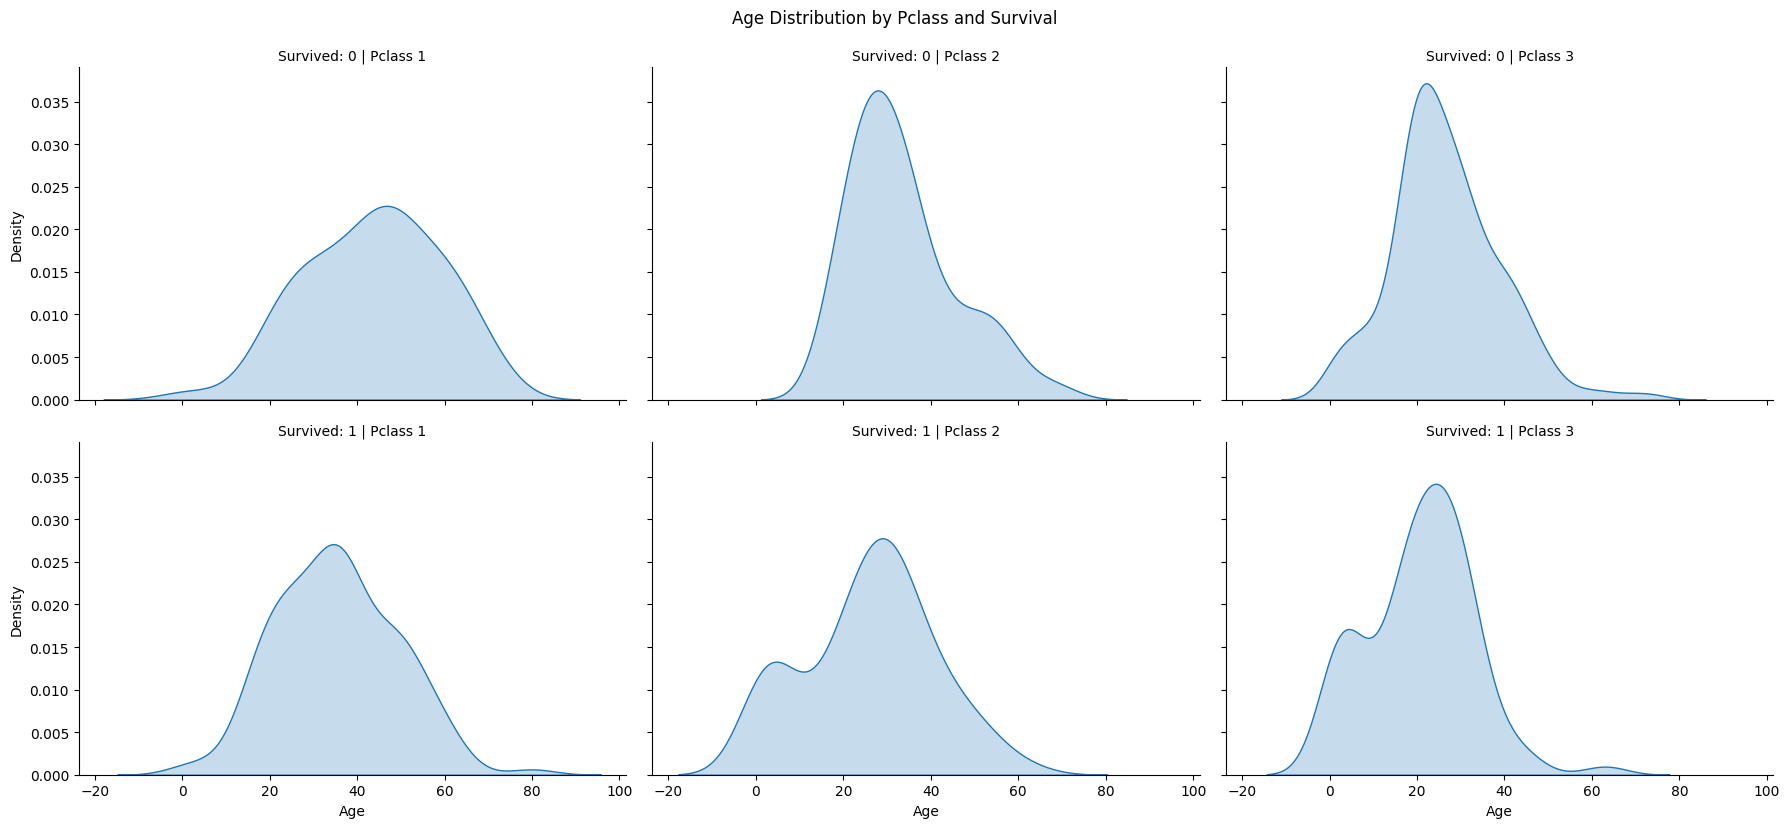

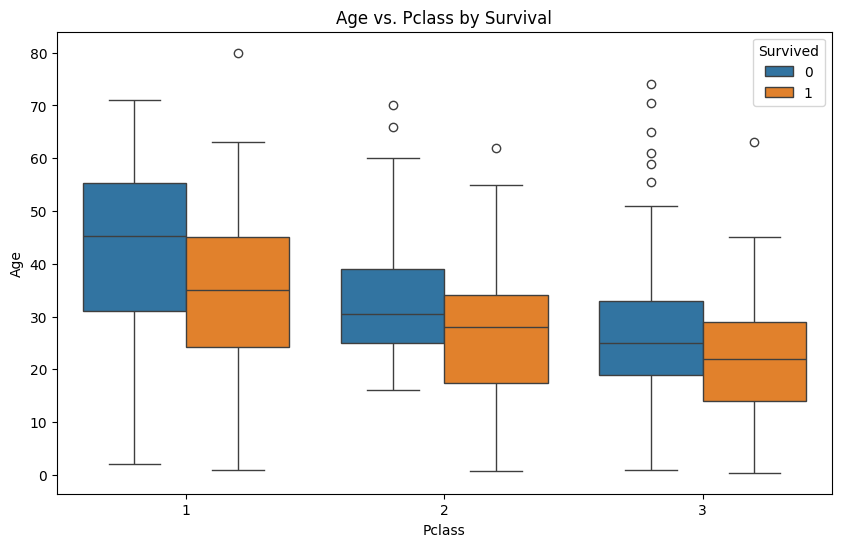

In [73]:
# How does Pclass interact with Age in shaping survival likelihood?

g = sns.FacetGrid(df, col='Pclass', row='Survived', height=4, aspect=1.5)
g.map(sns.kdeplot, 'Age', fill=True)
g.set_titles(col_template="Pclass {col_name}", row_template="Survived: {row_name}")
plt.suptitle("Age Distribution by Pclass and Survival", y=1.03)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Pclass', y='Age', hue='Survived')
plt.title("Age vs. Pclass by Survival")
plt.show()

How does Pclass interact with Age in shaping survival likelihood?

Class 1:

- Survivors are broadly distributed across all ages, including many older adults.

- Non-survivors also span a wide range, but with slightly fewer young passengers.

- Interpretation: Age appears less critical in Class 1—passengers of all ages had a fair chance of survival.

Class 2:

- Survivors are skewed younger (more children and young adults).

- Non-survivors peak sharply in the 20–40 range, with fewer children.

- Interpretation: Youth had an advantage in Class 2; older adults were less likely to survive.

Class 3:

- Survivors are concentrated in younger age groups, particularly children and teens.

- Non-survivors also peak in the 20–30 range, with a heavier tail toward older adults.

- Interpretation: In Class 3, age played a large role—children had a higher chance of survival, while older passengers rarely survived.



It seems the training data is missing data from Age, Cabin and Embarked that we have to deal with later. Of all the columns, PassengerId and Name is not really important factors to the prediction, while Survived is the response variable and {pclass, age, sex, sibsp, parch, ticket number, fare, cabin, embarked} are all input variables, with ticket number, fare and cabin being factors seemingly more disconnected to the survival rate.

In [25]:
#checking mode 
train_data.mode().iloc[0]

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

From the training data, the mode for categories Age, Cabin, and Embarked are 24.0, B96 B98, and S respectively. #bro the cabin got too much missing values idt the mode is accurate for cabin, the rest looks okay so far...

In [3]:
# Make new dataset with edited data
df_processed = train_data.copy()
df_processed["Embarked"] = df_processed["Embarked"].fillna(train_data["Embarked"].mode()[0])
df_processed = df_processed.drop(columns=["Cabin"])
df_processed = df_processed.dropna(subset=["Age"])

# View processed train data
print("Processed Train Data:")
print(df_processed.head())
print(df_processed.tail())

print("Processed Train Data Info:")
print(df_processed.info())


Processed Train Data:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  
0      0         A/5 21171   7.2500        S  
1      0          PC 17599  71.2833        C  
2      0  STON/O2. 3101282   7.9250        S  
3      0            113803  53.1000        S  
4      0            373450   8.0500        S  
     PassengerId

In [28]:
# postive cases
num_survived = df_processed["Survived"].sum()
print("postitive cases:" + str(num_survived))

# total cases
total = df_processed["Survived"].count()

# survival rate
percentage = (num_survived / total) * 100
print(f"Survived: {num_survived} / {total} ({percentage:.2f}%)")

postitive cases:290
Survived: 290 / 714 (40.62%)


We see that after processing the data, there are 290 positive survival cases, meaning that out of 714 passengers, 290 of them survived, aka there is a 40.62% survival rate. This is a slight imbalance in the dataset. (we may need to see if the model is biased towards the majority class, which is survive == 0)

We separate the train set into categorical and quantitative variables. PassengerId was dropped as it was treated as the index and Ticket and Name and cabin was also dropped as from first glance the data was quite messy and hard to decipher (left to be analysed later Race????). Survived was the categorical (binary: 0,1) dependent variable, with the rest being independent variables. The categorical independent variables are {Pclass, Sex, SibSp, Parch, Embarked}, while the quantitative independent variables are {Age, Fare}.

In [29]:
categorical_variables = ['Pclass','Sex','SibSp','Parch','Embarked']
quantitative_variables = ['Age','Fare']
dependent_variable = ['Survived']

In [30]:
from scipy.stats import chi2_contingency
import pandas as pd

for cat_var in categorical_variables:
    # Create contingency table
    ct = pd.crosstab(train_data[cat_var], train_data['Survived'], margins=True)
    print(f"\n=== {cat_var} vs Survived ===")
    print(ct)
    
    # Chi-square test
    chi2, p, dof, expected = chi2_contingency(ct.iloc[:-1, :-1])  # Exclude margins
    print(f"\nChi-square test:\nχ²={chi2:.2f}, p={p:.4f}, df={dof}")
    
    # Calculate metrics based on table size
    if ct.shape == (3, 3):  # 2x2 table (excluding margins)
        # Odds Ratio
        oddsratio = (ct.iloc[0,0] * ct.iloc[1,1]) / (ct.iloc[0,1] * ct.iloc[1,0])
        print(f"\nOdds Ratio: {oddsratio:.2f}")
    else:
        # Conditional Probability (P(Survived=1 | Category))
        print("\nConditional Probabilities (P(Survived | Category)):")
        prob_df = pd.DataFrame({
            'Category': ct.index[:-1],
            'P(Survived=1)': ct.iloc[:-1, 1] / ct.iloc[:-1, 2]  # Survived / Total
        })
        print(prob_df.round(2))
    
    print("\n" + "-"*50)


=== Pclass vs Survived ===
Survived    0    1  All
Pclass                 
1          80  136  216
2          97   87  184
3         372  119  491
All       549  342  891

Chi-square test:
χ²=102.89, p=0.0000, df=2

Conditional Probabilities (P(Survived | Category)):
       Category  P(Survived=1)
Pclass                        
1             1           0.63
2             2           0.47
3             3           0.24

--------------------------------------------------

=== Sex vs Survived ===
Survived    0    1  All
Sex                    
female     81  233  314
male      468  109  577
All       549  342  891

Chi-square test:
χ²=260.72, p=0.0000, df=1

Odds Ratio: 0.08

--------------------------------------------------

=== SibSp vs Survived ===
Survived    0    1  All
SibSp                  
0         398  210  608
1          97  112  209
2          15   13   28
3          12    4   16
4          15    3   18
5           5    0    5
8           7    0    7
All       549  342  89

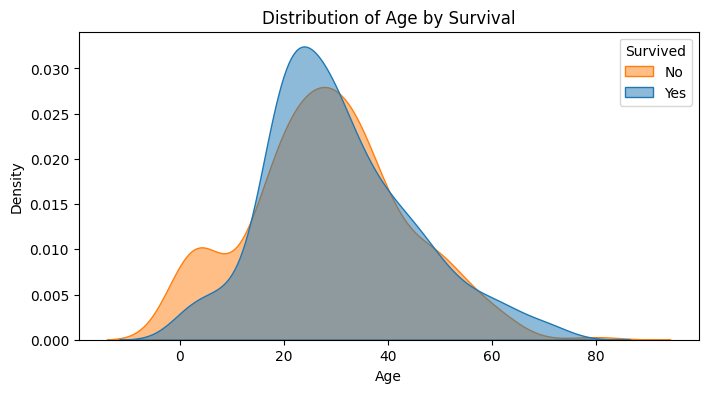

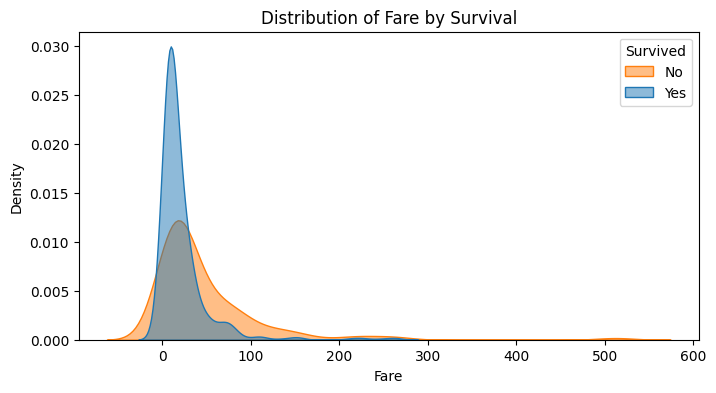

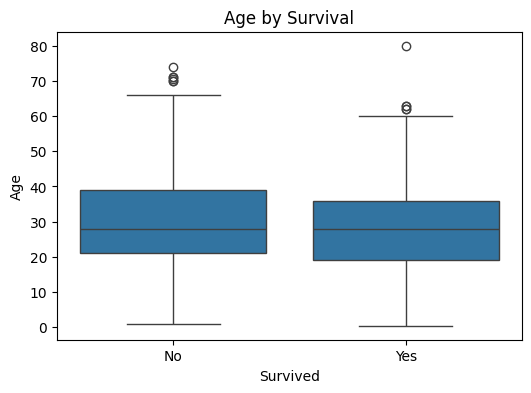

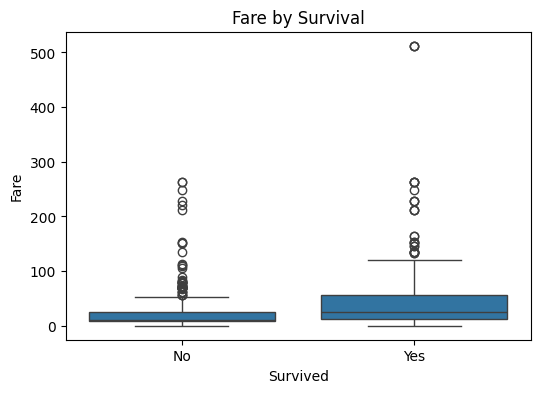

Age: Mann-Whitney U test p-value = 0.1605
Fare: Mann-Whitney U test p-value = 0.0000


In [31]:
# Plot distributions of quantitative variables by survival
for var in quantitative_variables:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=train_data, x=var, hue='Survived', common_norm=False, fill=True, alpha=0.5)
    plt.title(f'Distribution of {var} by Survival')
    plt.xlabel(var)
    plt.ylabel('Density')
    plt.legend(title='Survived', labels=['No', 'Yes'])
    plt.show()

# Boxplots for quantitative variables by survival
for var in quantitative_variables:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=train_data, x='Survived', y=var)
    plt.title(f'{var} by Survival')
    plt.xlabel('Survived')
    plt.ylabel(var)
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()

# Statistical test: Compare distributions (Mann-Whitney U test)
for var in quantitative_variables:
    survived = train_data[train_data['Survived'] == 1][var].dropna()
    not_survived = train_data[train_data['Survived'] == 0][var].dropna()
    stat, pval = stats.mannwhitneyu(survived, not_survived, alternative='two-sided')
    print(f"{var}: Mann-Whitney U test p-value = {pval:.4f}")

We see that the fare is right skewed, hence we will log the fare values

In [4]:
import numpy as np
df_processed["Log_Fare"] = np.log(df_processed["Fare"] + 0.01)  # Adding 0.01 to avoid log(0)

In [5]:
# Save cleaned data to CSV
print("Original rows:", len(train_data))        
df_processed.to_csv('../data/processed/train_processed.csv', index=False)

Original rows: 891


In [6]:
# Checking the processed data

import pandas as pd

df_processed = pd.read_csv('../data/processed/train_processed.csv')
print(df_processed.head())
print(df_processed.describe())
print(df_processed.info())
# There are no more missing data. 

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Embarked  Log_Fare  
0      0         A/5 21171   7.2500        S  1.982380  
1      0          PC 17599  71.2833        C  4.266802  
2      0  STON/O2. 3101282   7.9250        S  2.071283  
3      0            113803  53.1000        S  3.972365  
4      0            373450   8.0500

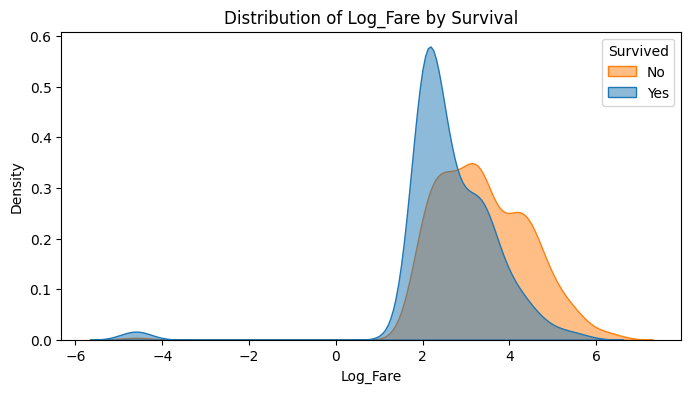

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.kdeplot(data=df_processed, x='Log_Fare', hue='Survived', common_norm=False, fill=True, alpha=0.5)
plt.title(f'Distribution of Log_Fare by Survival')
plt.xlabel('Log_Fare')
plt.ylabel('Density')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

# Fare is mostly normal now.